In [1]:
# Settings for MatplotLib for paper and just good plots
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import seaborn as sns
import random

In [3]:
import tensorflow as tf
from tensorflow import keras

In [40]:
import utilities as utils

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
plt.rc('mathtext', **{'default':'regular'})
plt.style.use(['seaborn-white', 'seaborn-paper'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

def stylize_axes(ax):
    # removes the top and right lines from the plot rectangle
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)
    
def save_image(fig, title):
    if title is not None:
        fig.savefig('results/'+title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig('results/'+title+".pdf", bbox_inches='tight')

In [42]:
# Load the dataset
n_window_len = 128
file = open('results/mhealth_processed_data_size_' + str(n_window_len) + '.pickle', 'rb')
x_tr, y_tr, x_ts, y_ts, mhealth_activities = pickle.load(file)
file.close()

In [7]:
# Load the saved model 
tr_model = tf.keras.models.load_model('results/cnn_trained_model_mheatlh.h5')

In [8]:
del mhealth_activities[11]

In [9]:
mhealth_activities

['Standing',
 'Sitting',
 'Lying',
 'Walking',
 'Climbing Stairs',
 'Waist Bend Forward',
 'Frontal Elevation Arms',
 'Knees Bending',
 'Cycling',
 'Jogging',
 'Running']

In [10]:
# The first step will be to visulaize one samples from some selected class. 
# These classes are selected because of their differences with respect to other classes
# I have selected the following classes: Sitting (1), Walking (3), Climbing Stairs (4), Running (10), Knees Bending (7), 
# Cycling (8)
# Also we will visualize the samples from the test set only, because later we will be using test set to generate adversarial 
# examples and visualize them again.
sitting_value = mhealth_activities.index('Sitting')
sitting_index = random.choice([i for i, e in enumerate(y_ts) if e == sitting_value])
sitting_sample = x_ts[sitting_index]

walking_value = mhealth_activities.index('Walking')
walking_index = random.choice([i for i, e in enumerate(y_ts) if e == walking_value])
walking_sample = x_ts[walking_index]

stairs_value = mhealth_activities.index('Climbing Stairs')
stairs_index = random.choice([i for i, e in enumerate(y_ts) if e == stairs_value])
stairs_sample = x_ts[stairs_index]

running_value = mhealth_activities.index('Running')
running_index = random.choice([i for i, e in enumerate(y_ts) if e == running_value])
running_sample = x_ts[running_index]

bending_value = mhealth_activities.index('Knees Bending')
bending_index = random.choice([i for i, e in enumerate(y_ts) if e == bending_value])
bending_sample = x_ts[bending_index]

cycling_value = mhealth_activities.index('Cycling')
cycling_index = random.choice([i for i, e in enumerate(y_ts) if e == cycling_value])
cycling_sample = x_ts[cycling_index]

In [11]:
def plot_sample(sample, class_):
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 8), sharex=True)
    ax[0].plot(sample[:, 0], label='X')
    ax[0].legend()
    stylize_axes(ax[0])
    
    ax[1].plot(sample[:, 1], label='Y', c='r')
    ax[1].legend()
    stylize_axes(ax[1])
    
    ax[2].plot(sample[:, 2], label='Z', c='g')
    ax[2].legend()
    stylize_axes(ax[2])
    
    fig.suptitle("A sample for class "+ class_, fontsize='xx-large')
    #plt.show()
    save_image(fig, "A Sample for class "+ class_)

In [12]:
selected_samples = [sitting_sample, walking_sample, stairs_sample, running_sample, bending_sample, cycling_sample]
selected_index = [sitting_index, walking_index, stairs_index, running_index, bending_index, cycling_index]
selected_class = ['Sitting', 'Walking', 'Climbing Stairs', 'Running', 'Knees Bending', 'Cycling']

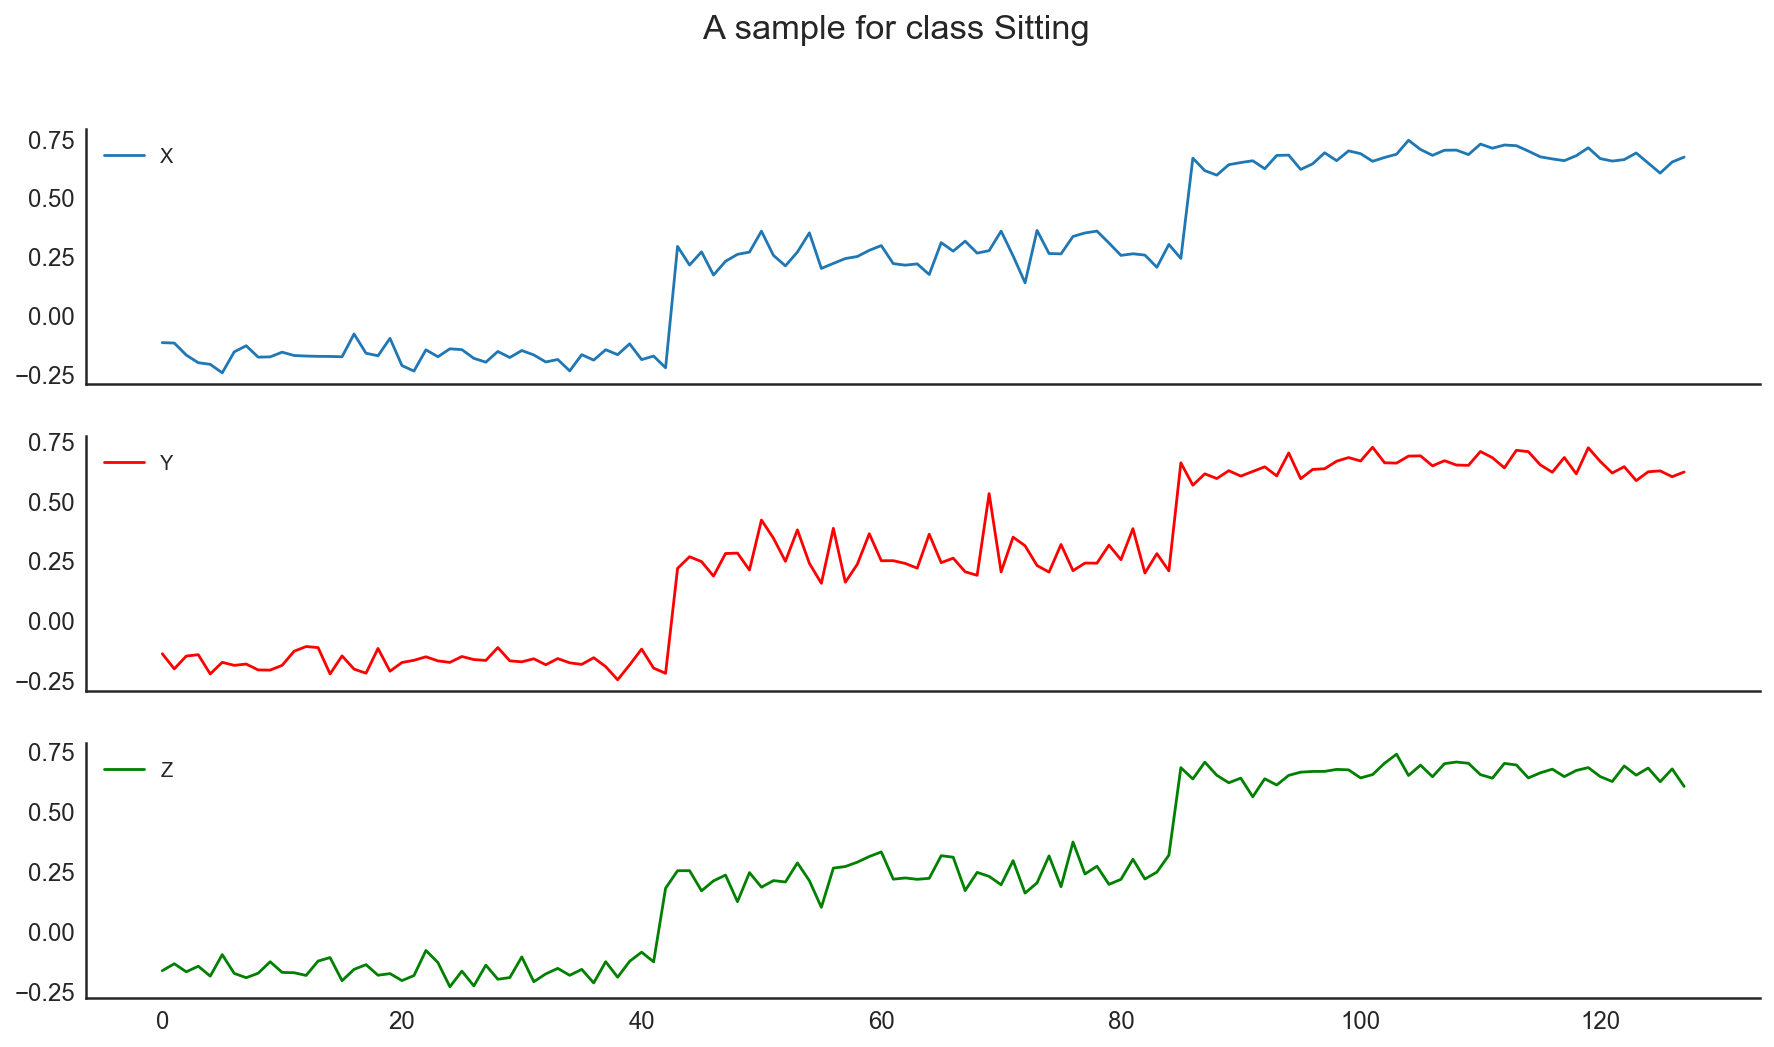

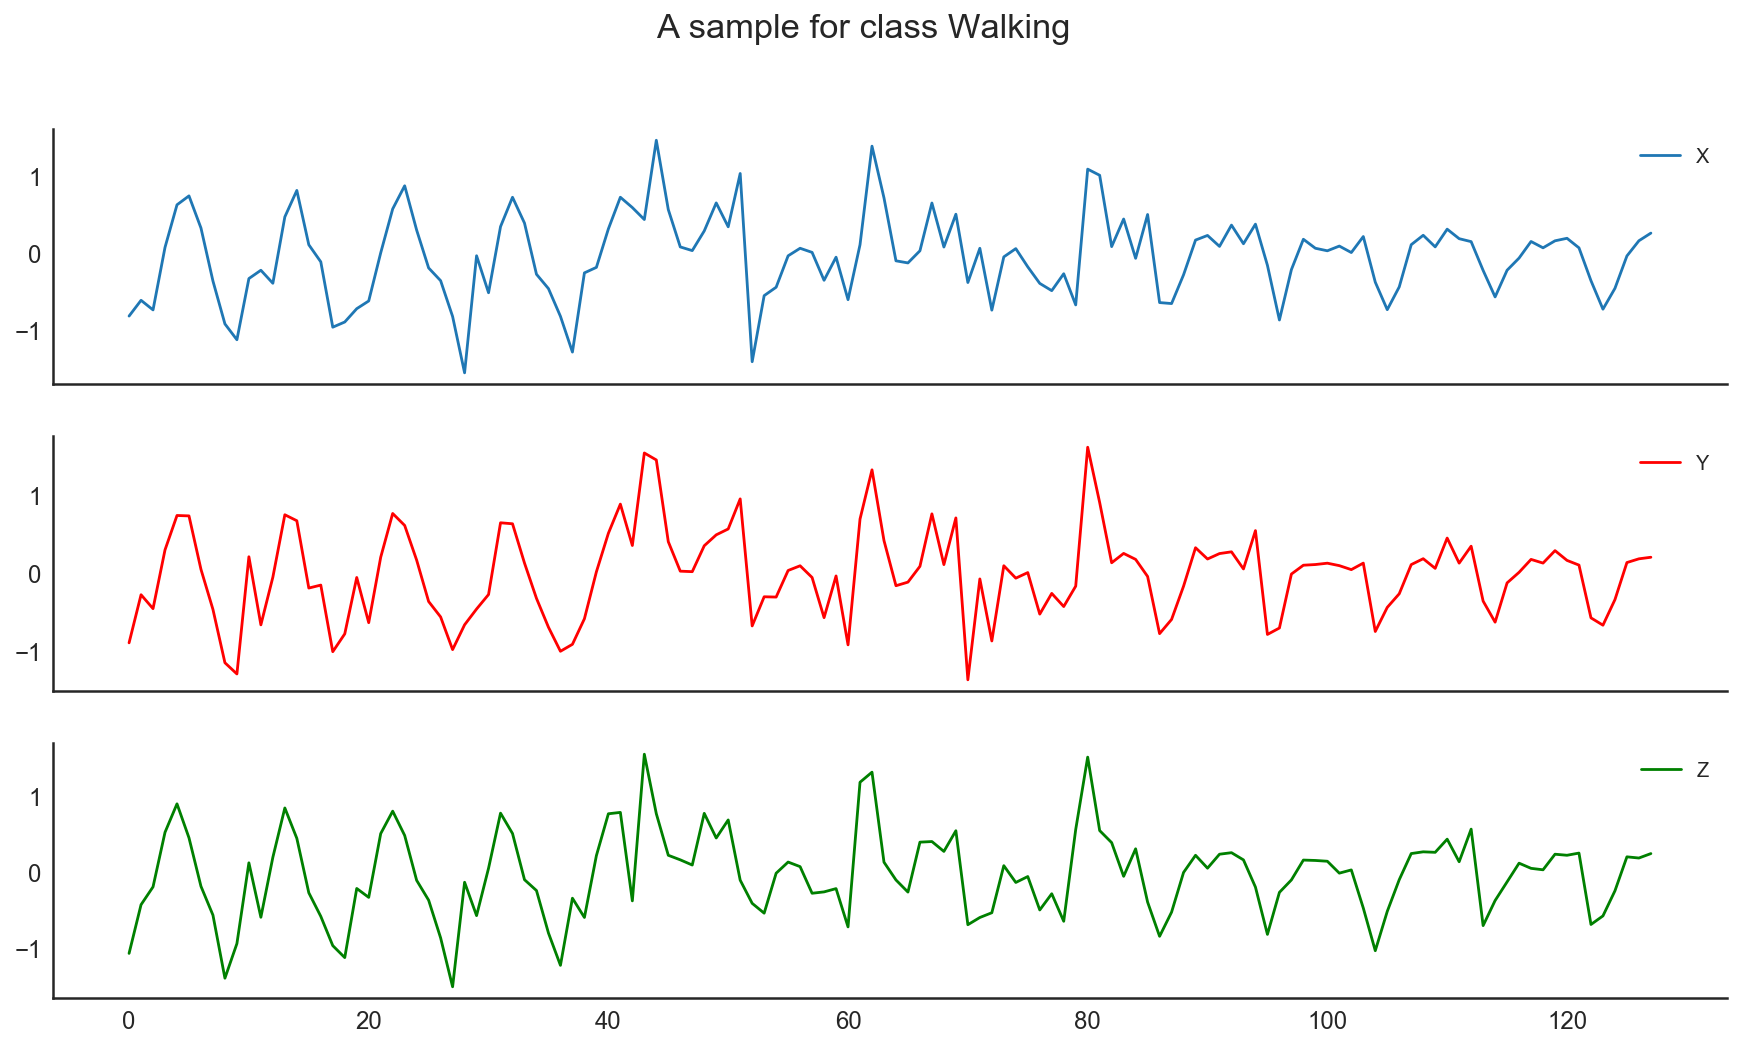

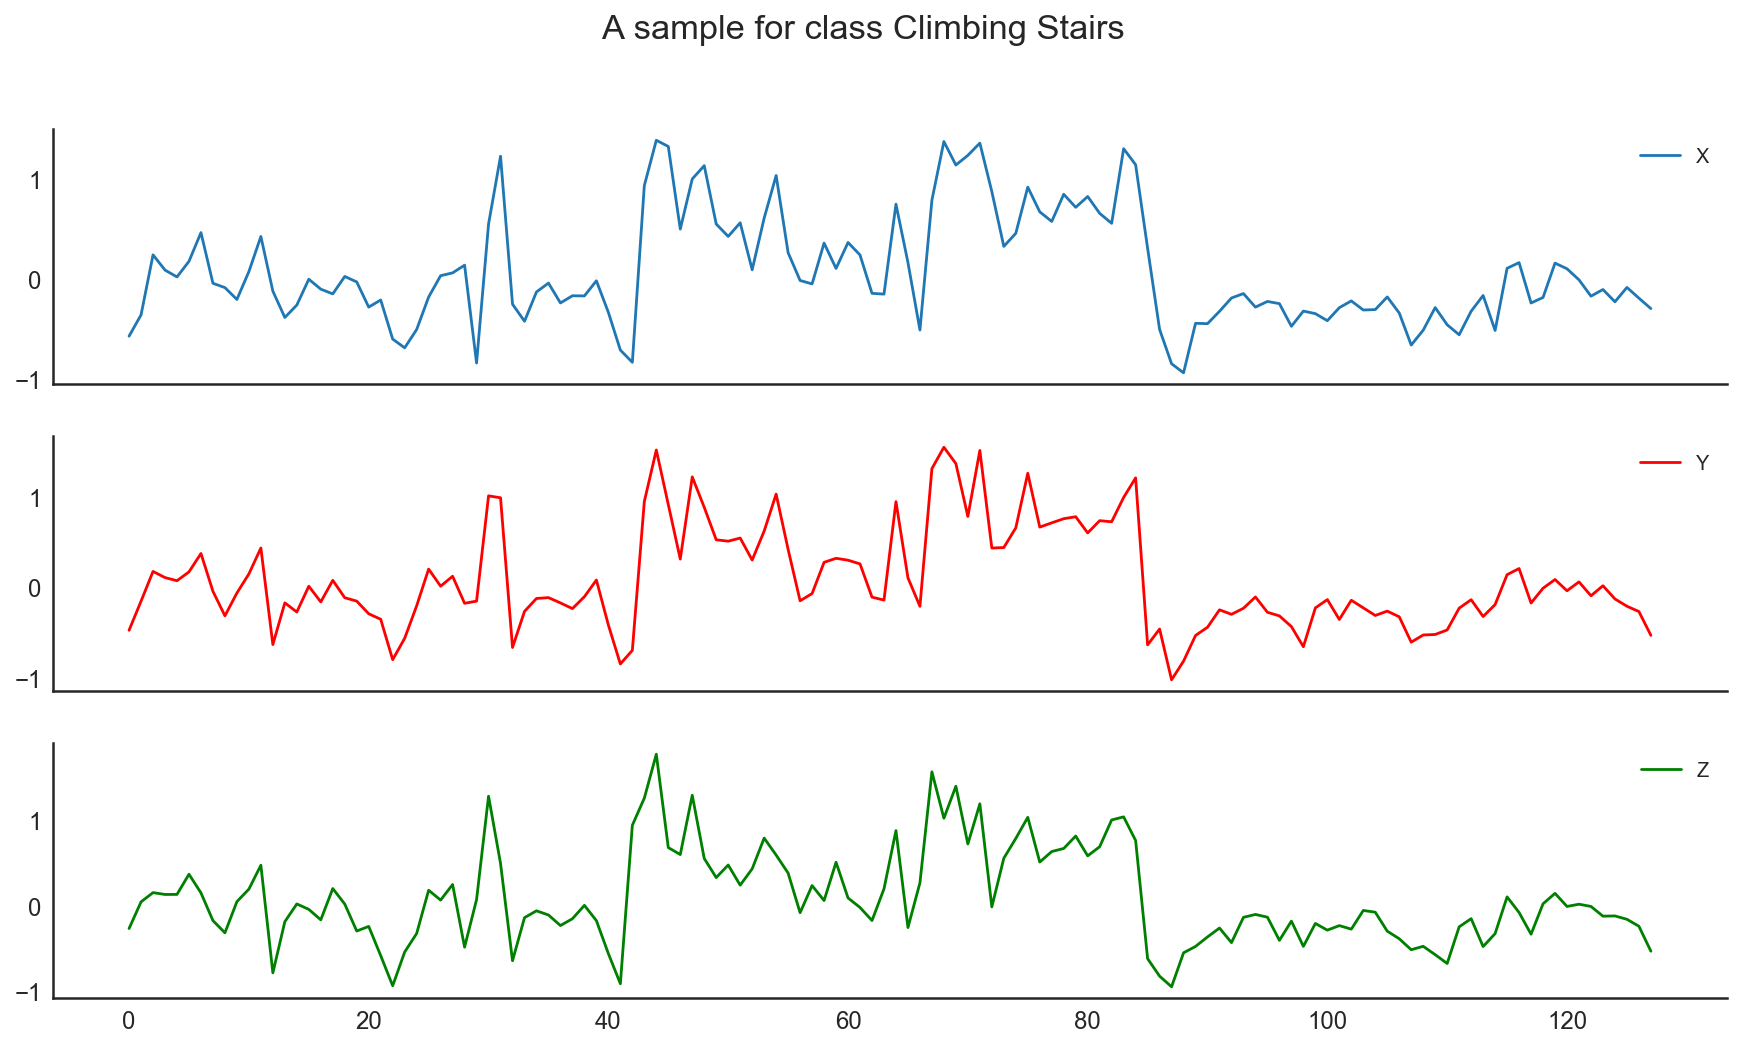

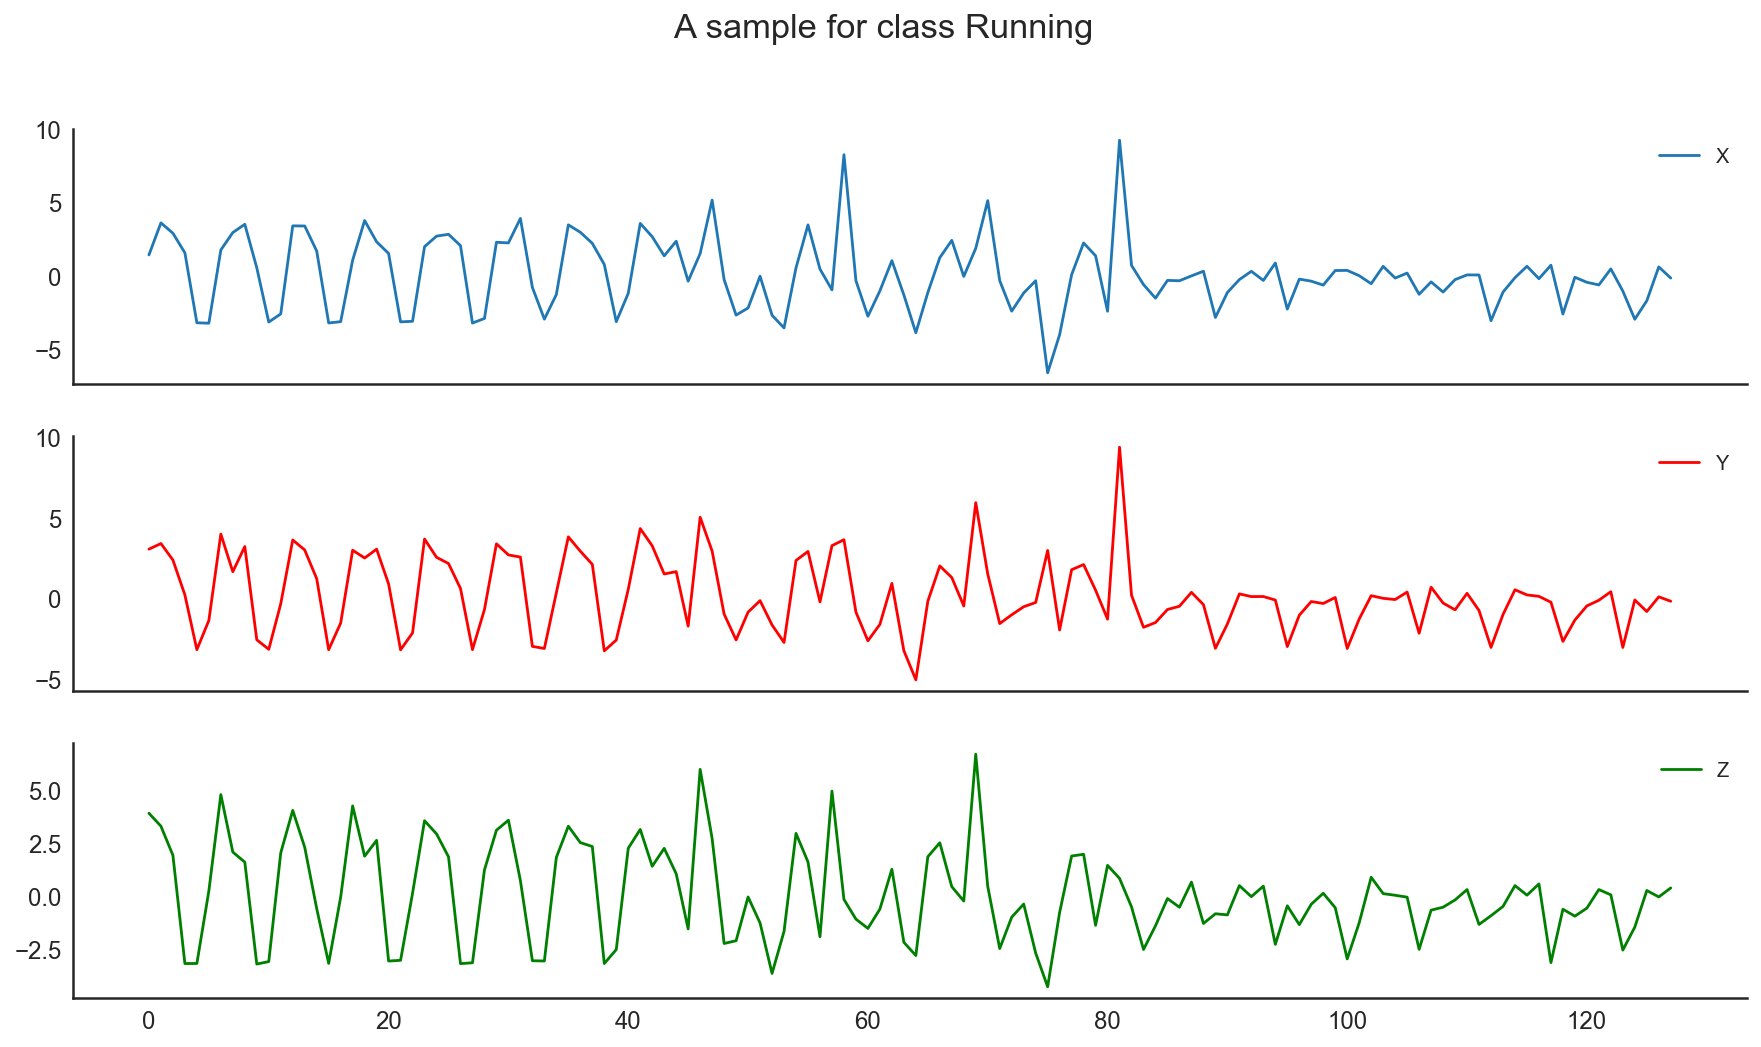

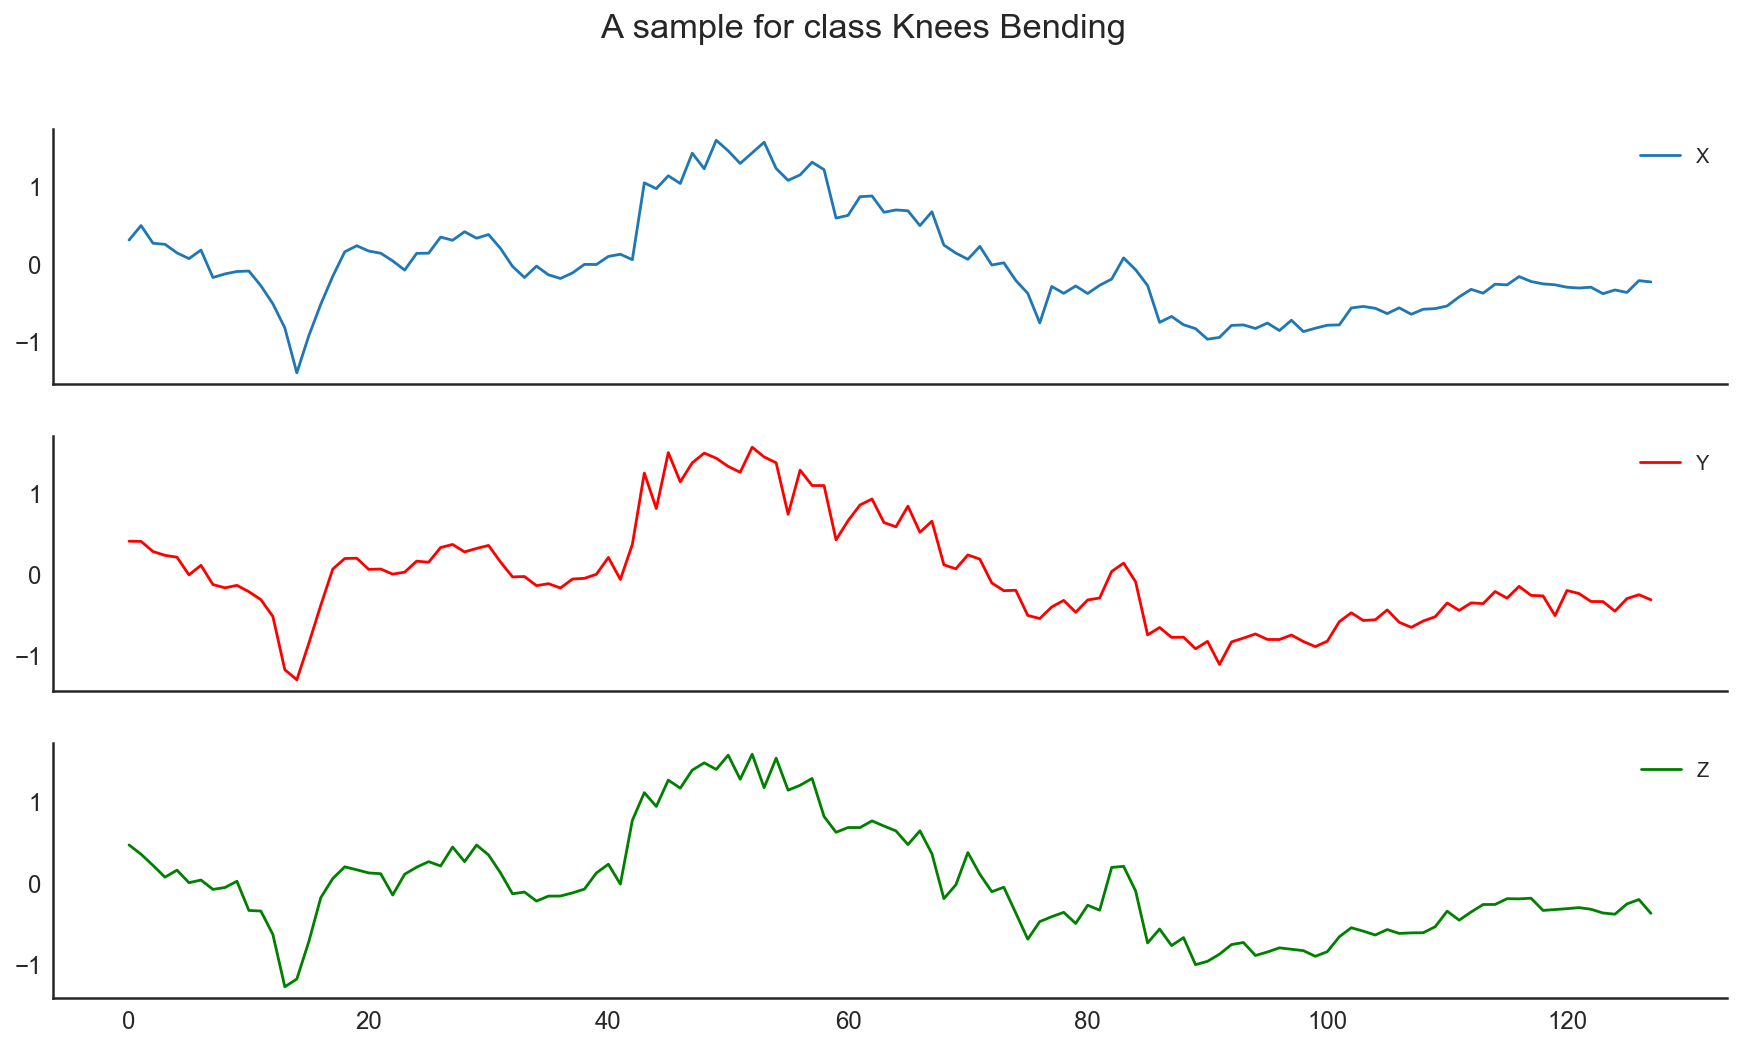

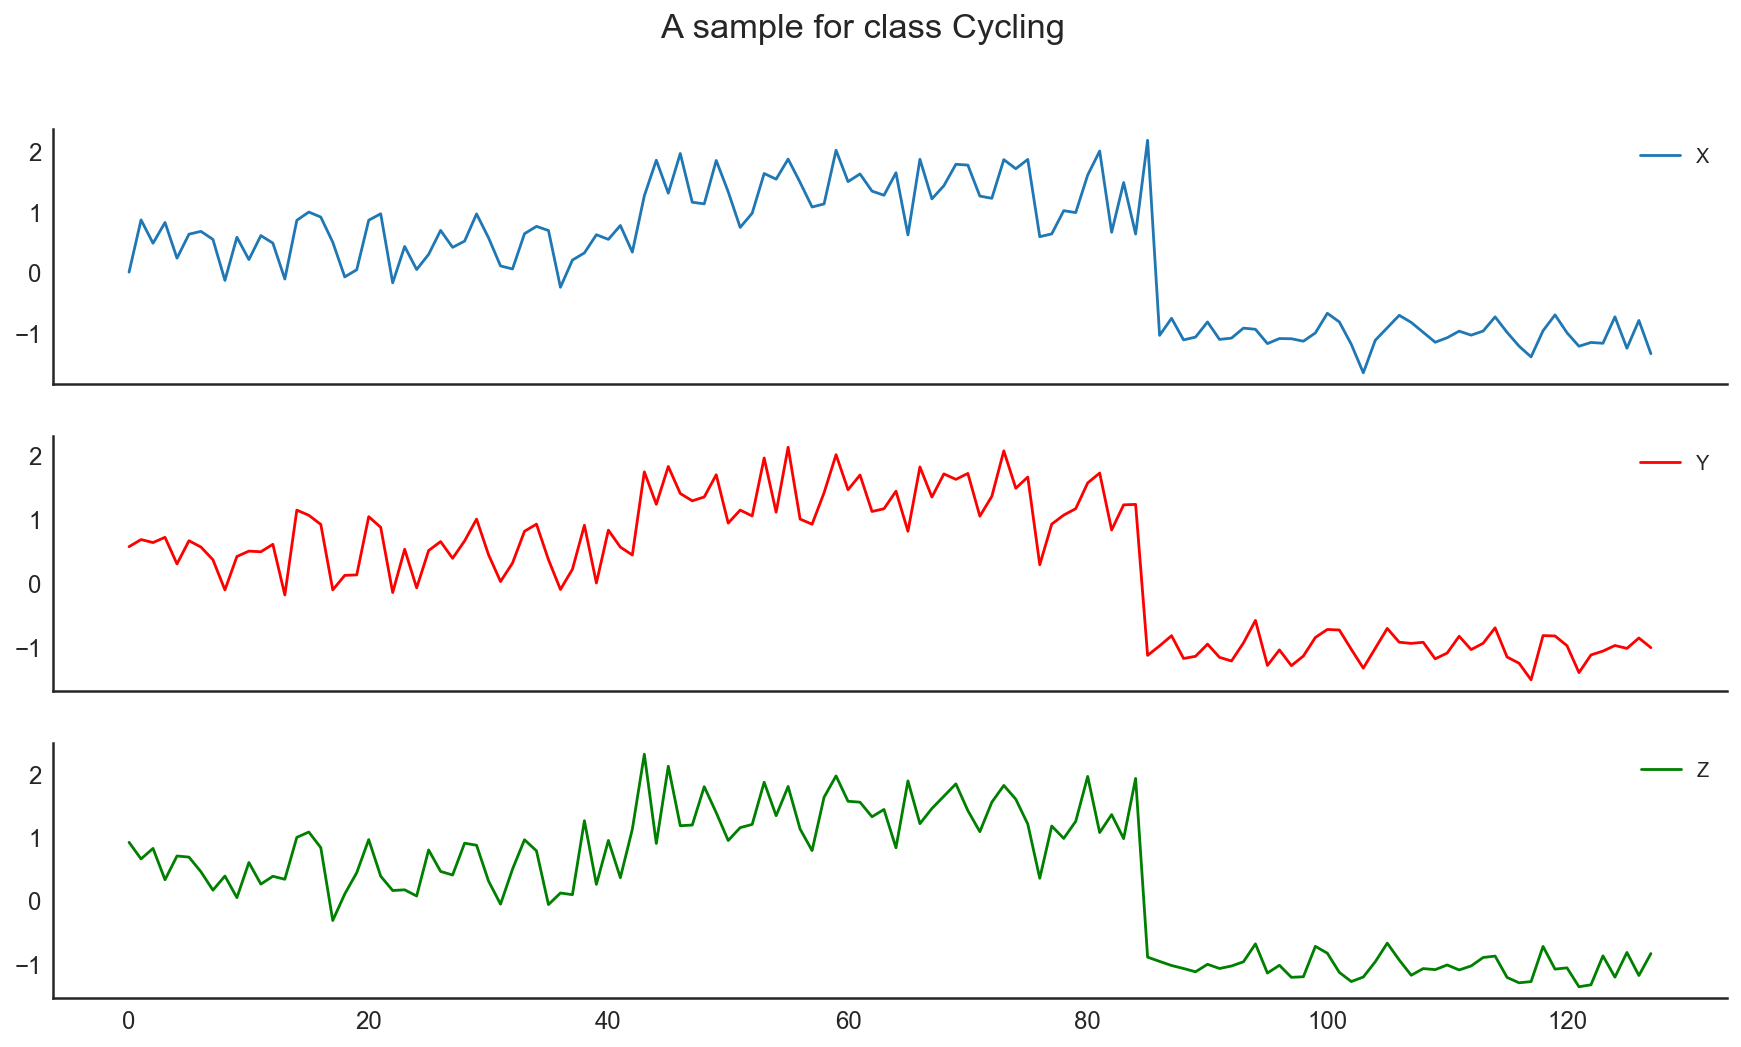

In [13]:
for s, nm in zip(selected_samples, selected_class):
    plot_sample(s, nm)

# Class Activation Maps

https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [14]:
# Extracting weights from final layer and Building a Model to output the feature maps as well as the final predicted class
model = tr_model
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 11)

In [15]:
from tensorflow.keras.models import Model
import scipy as sp

In [16]:
model.layers

In [17]:
cam_model = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))

In [18]:
features, results = cam_model.predict(x_ts)

In [19]:
features.shape

(1248, 128, 128)

In [20]:
results.shape

(1248, 11)

In [37]:
# https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html
def plot_activation_map(idx, features, results, name=None):
    features_for_one_seg = features[idx, :, :]
    print(features_for_one_seg.shape)
    height_roomout = x_ts.shape[1] / features_for_one_seg.shape[0]
    width_roomout = x_ts.shape[2] / features_for_one_seg.shape[1]
    
    cam_features = sp.ndimage.zoom(features_for_one_seg, (height_roomout, width_roomout), order = 2)
    prediction = np.argmax(results[idx])
    cam_features = features_for_one_seg
    cam_weights = gap_weights[:, prediction]
    cam_output = np.dot(cam_features, cam_weights)
    
    buf = 'Predicted class ' + mhealth_activities[prediction] + ", Probability " + str(results[idx][prediction])
    x = np.arange(128)
    dydx = cam_output

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize = (16, 8), sharex = True)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(dydx.min(), dydx.max())
    
    lbs = ['X', 'Y', 'Z']
    for i in range(3):
        y = x_ts[idx, :, i]
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='viridis', norm=norm, label = lbs[i])
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(2)
        line = axs[i].add_collection(lc)
        axs[i].set_xlim(x.min(), x.max())
        axs[i].set_ylim(y.min() - 0.2, y.max() + 0.1)
        axs[i].legend(loc = 2)
        stylize_axes(axs[i])
    
    cbar = fig.colorbar(line, ax=axs.ravel().tolist(), shrink=0.95)
    plt.xlabel(buf, fontsize='xx-large')
    fig.suptitle("Activation Map for " + name + " class sample.", fontsize='xx-large')
    plt.show()
    save_image(fig, "Activation Map for " + name + " class sample.")

(128, 128)


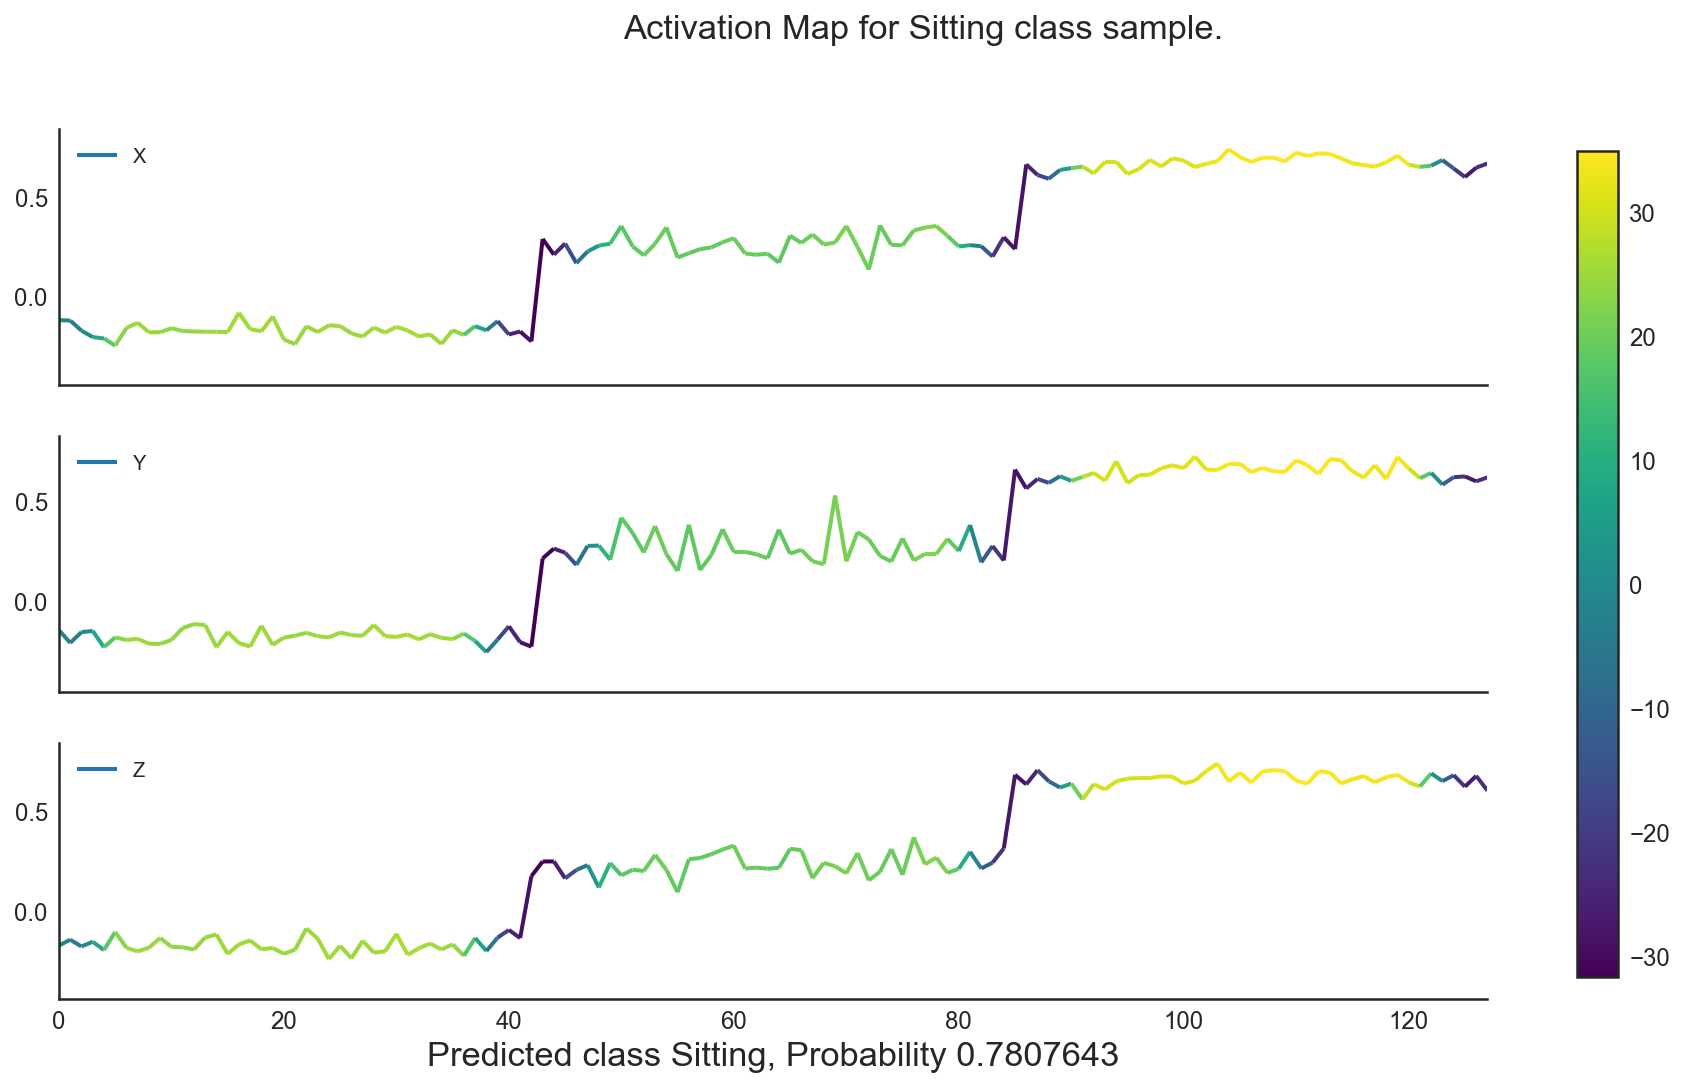

(128, 128)


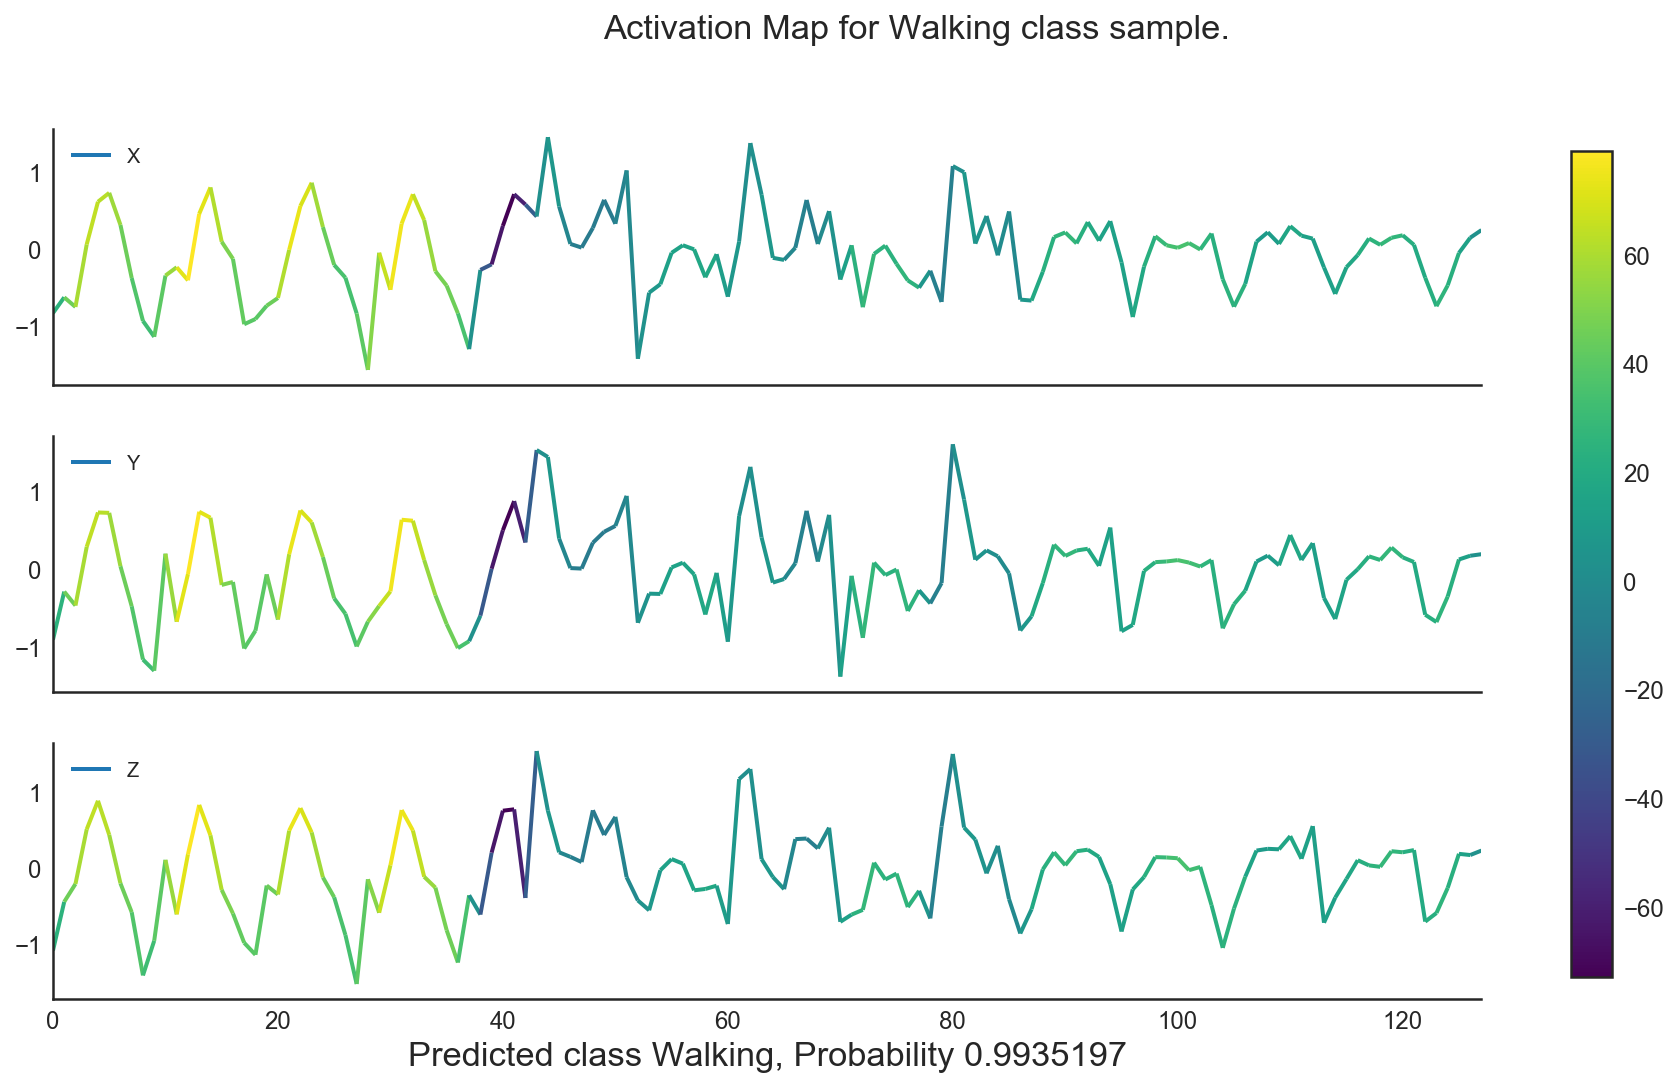

(128, 128)


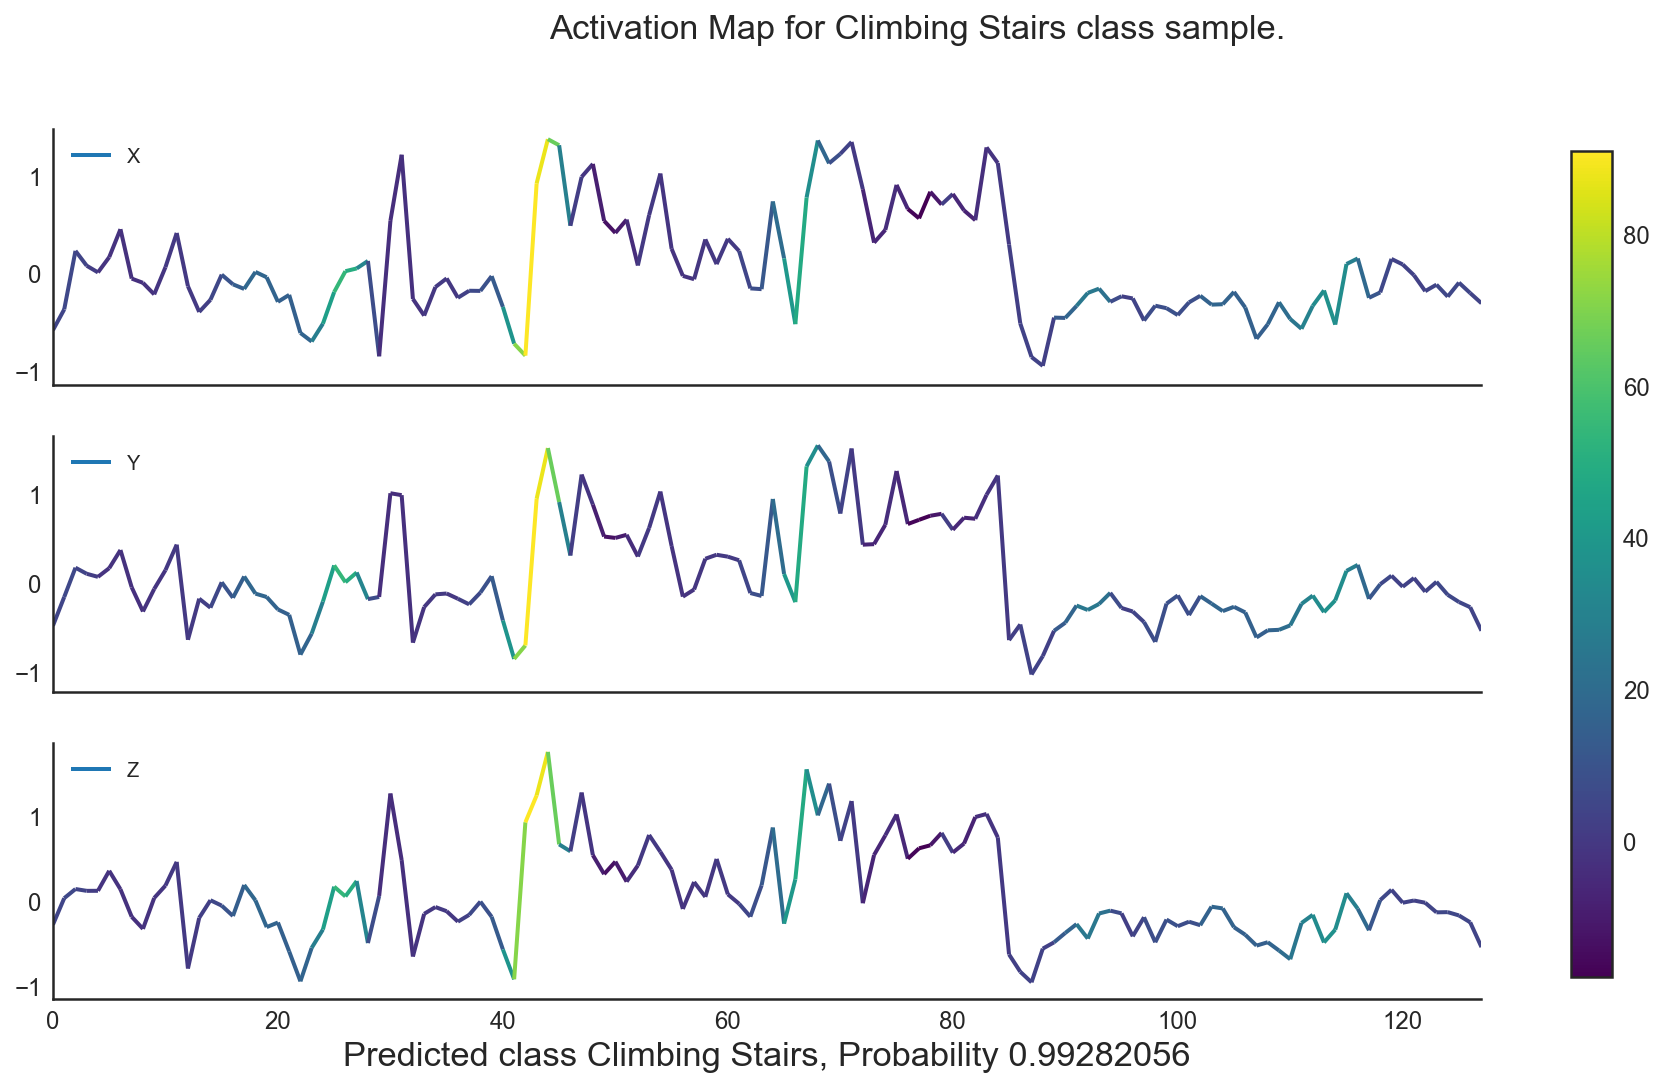

(128, 128)


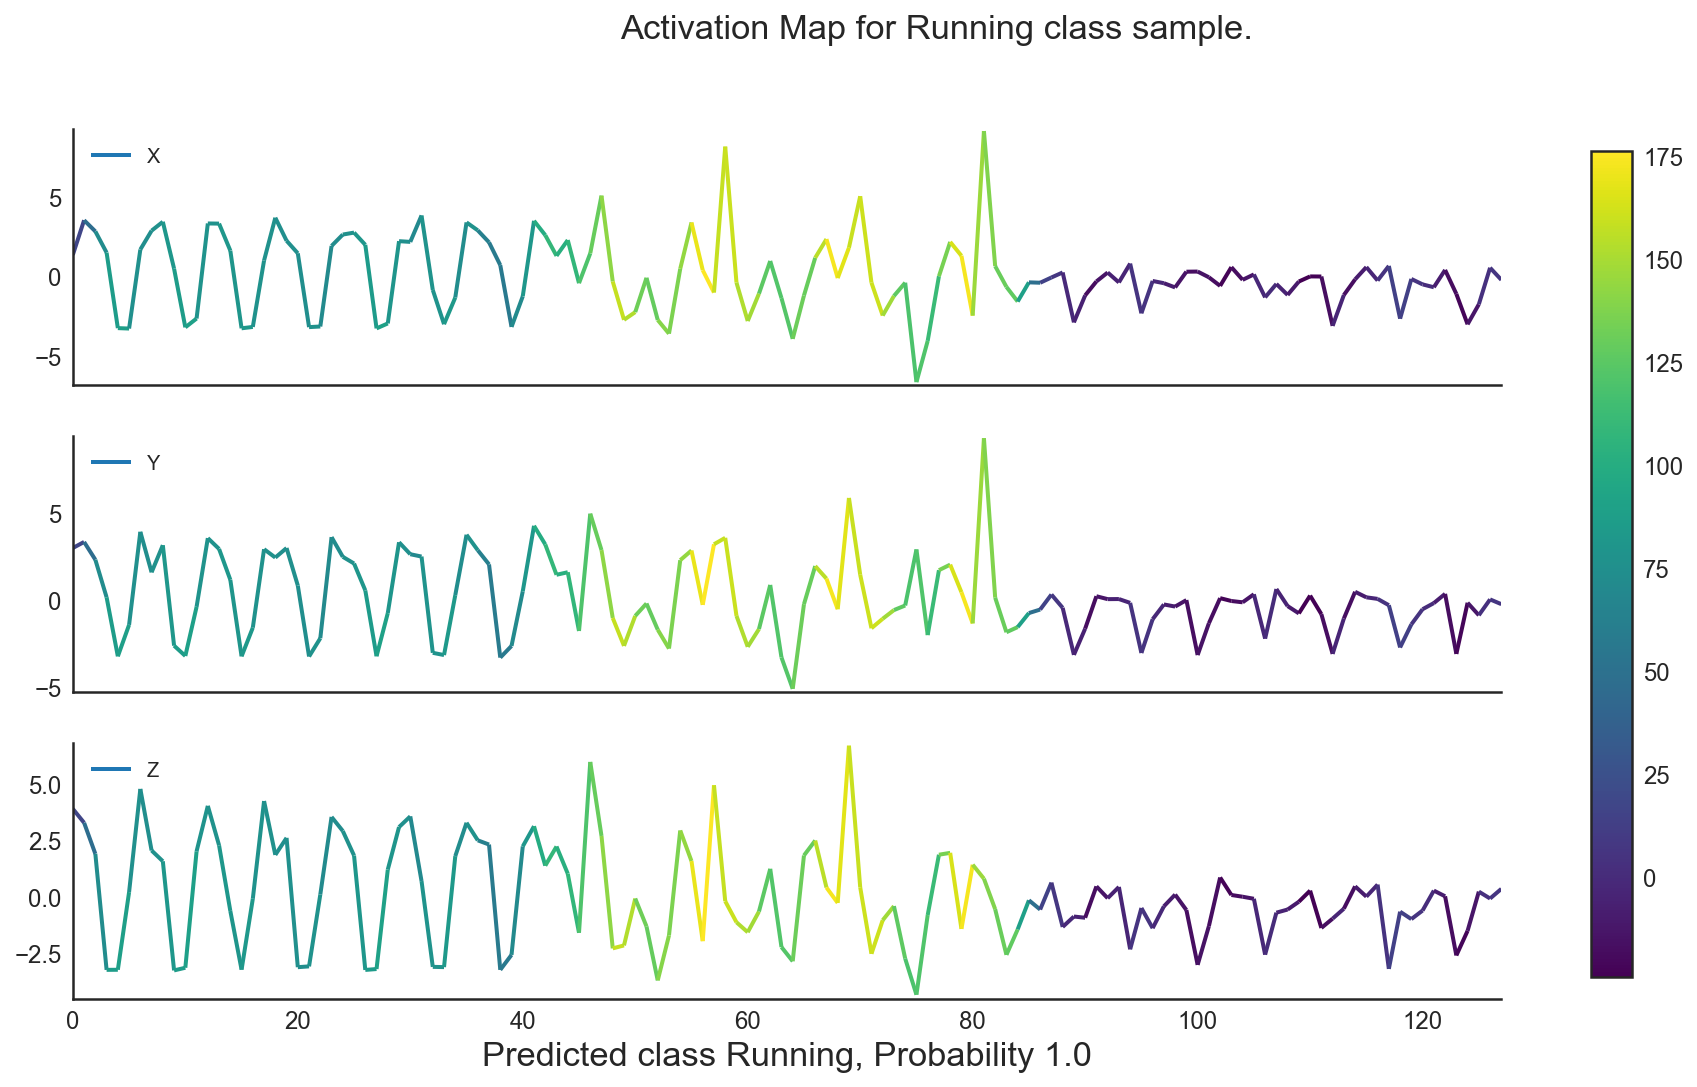

(128, 128)


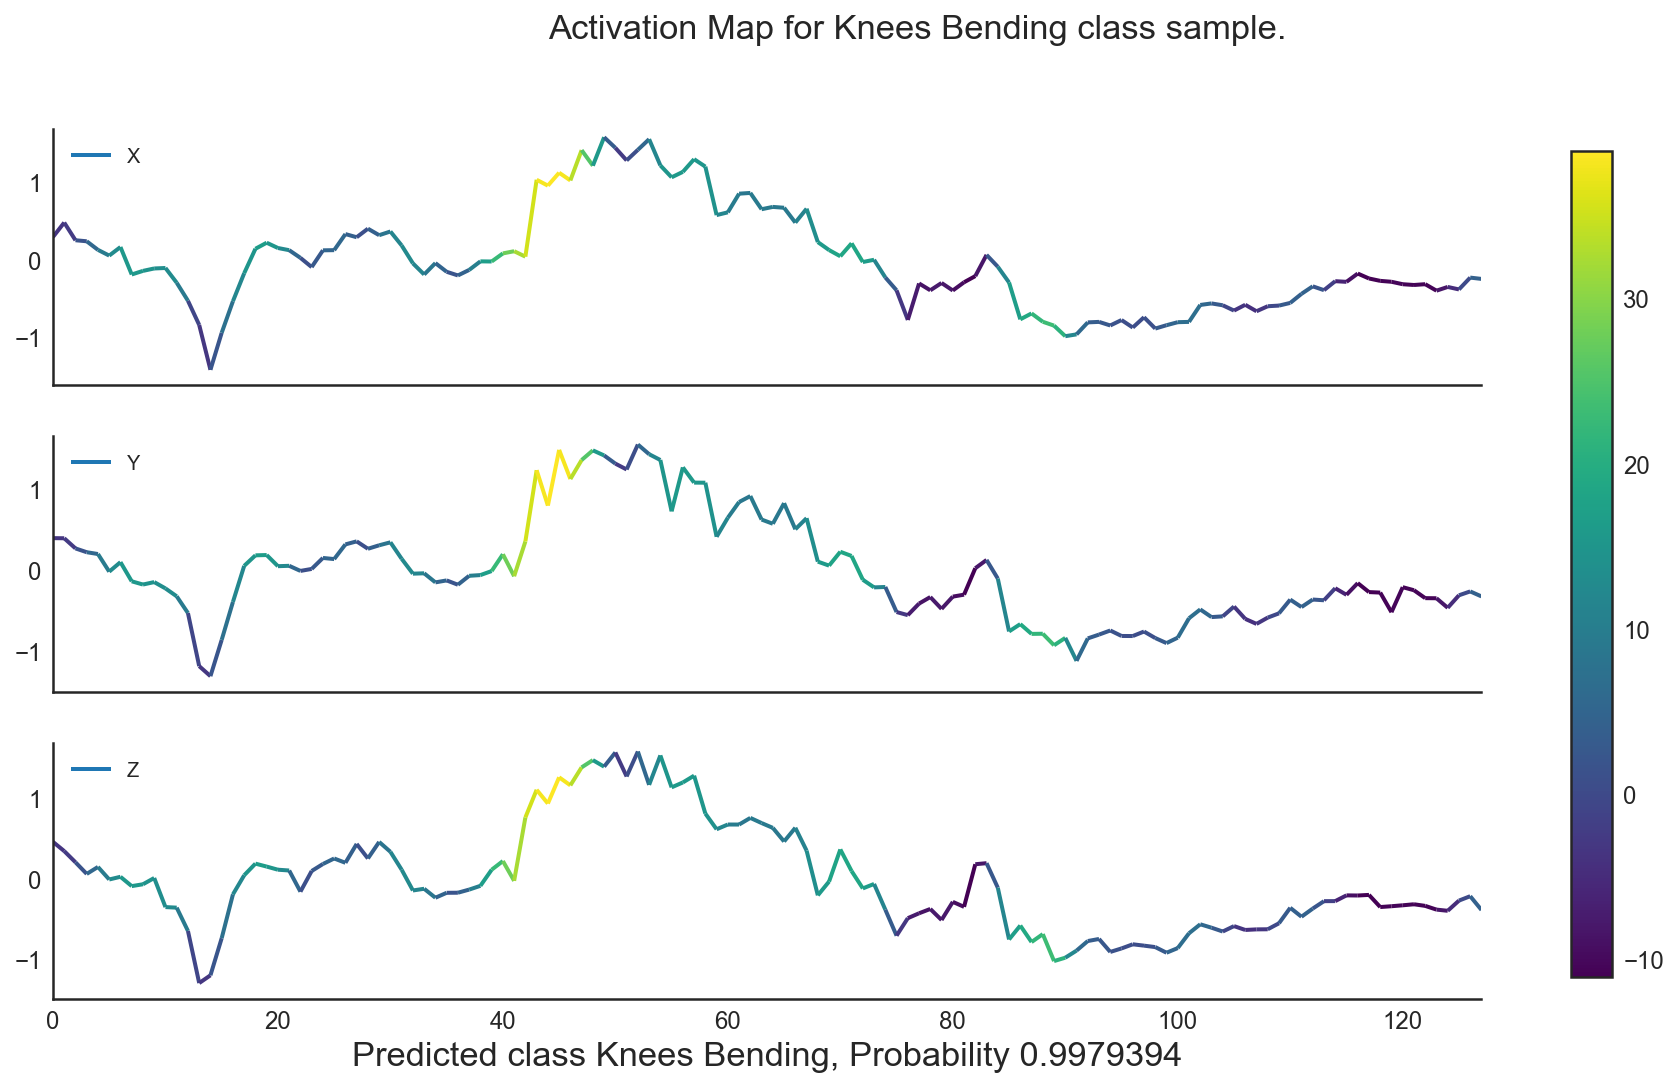

(128, 128)


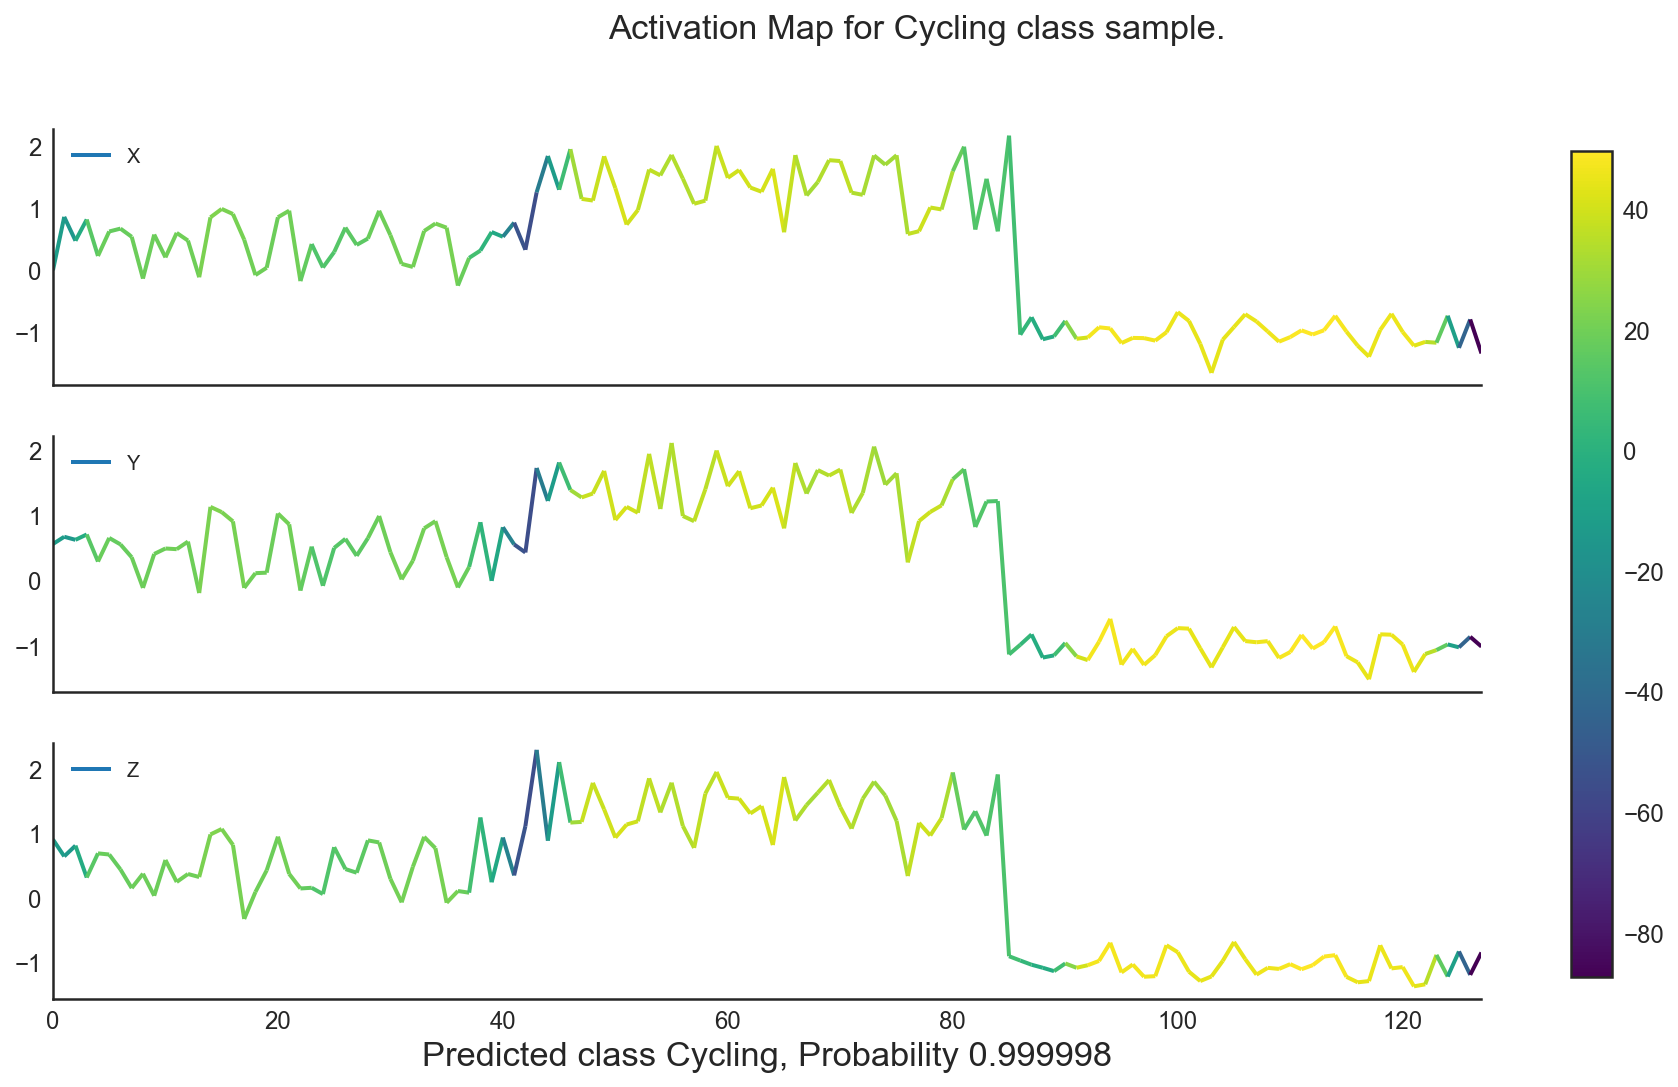

In [43]:
for index, name in zip(selected_index, selected_class):
    plot_activation_map(index, features, results, name)